In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import configparser

In [9]:
config = configparser.ConfigParser()
config.read('config.ini')

train_file_path = config['Paths']['train_file']
test_file_path = config['Paths']['test_file']

train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

X_train = train.iloc[:, :-1]  # features in the training data
y_train = train.iloc[:, -1]    # labels in the training data

X_test = test.values    # features in the testing data (no labels)

In [10]:
class GaussianNaiveBayes:
    """
    A Gaussian Naive Bayes classifier implementation for continuous data.

    Attributes:
        None

    Methods:
        - fit(X, y): Fit the classifier to the training data.
        - predict(X): Predict the class labels for a set of input samples.

    """
    def fit(self, X, y):
        """
        Fit the Gaussian Naive Bayes classifier to the training data.

        Parameters:
            X (numpy.ndarray): Training data with shape (n_samples, n_features).
            y (numpy.ndarray): Target labels with shape (n_samples,).

        Returns:
            None

        """
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for i, c in enumerate(self._classes):
            X_for_class_c = X[y == c]
            self._mean[i, :] = X_for_class_c.mean(axis=0)
            self._var[i, :] = X_for_class_c.var(axis=0)
            self._priors[i] = X_for_class_c.shape[0] / float(n_samples)

    def _calculate_likelihood(self, class_idx, x):
        """
        Calculate the likelihood for a sample belonging to a class.

        Parameters:
            class_idx (int): Index of the target class.
            x (numpy.ndarray): Input sample.

        Returns:
            numpy.ndarray: Array of likelihood values.

        """
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        num = np.exp(- (x - mean) ** 2 / (2 * var))
        denom = np.sqrt(2 * np.pi * var)
        return num / denom

    def predict(self, X):
        """
        Predict the class labels for a set of input samples.

        Parameters:
            X (numpy.ndarray): Input samples with shape (n_samples, n_features).

        Returns:
            numpy.ndarray: Predicted class labels for the input samples.

        """
        y_pred = [self._classify_sample(x) for x in X]
        return np.array(y_pred)

    def _classify_sample(self, x):
        """
        Classify a single input sample into one of the classes.

        Parameters:
            x (numpy.ndarray): Input sample.

        Returns:
            int: Predicted class label for the input sample.

        """
        posteriors = []

        for i, c in enumerate(self._classes):
            prior = np.log(self._priors[i])
            posterior = np.sum(np.log(self._calculate_likelihood(i, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

In [27]:
import numpy as np

class MultinomialNaiveBayes:
    """
    A Multinomial Naive Bayes classifier implementation for discrete data.

    Attributes:
        None

    Methods:
        - fit(X, y): Fit the classifier to the training data.
        - predict(X): Predict the class labels for a set of input samples.

    """
    def fit(self, X, y):
        """
        Fit the Multinomial Naive Bayes classifier to the training data.

        Parameters:
            X (numpy.ndarray): Training data with shape (n_samples, n_features) representing word counts or frequencies.
            y (numpy.ndarray): Target labels with shape (n_samples,).

        Returns:
            None

        """
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        self._class_counts = np.zeros(n_classes, dtype=np.float64)
        self._feature_counts = np.zeros((n_classes, n_features), dtype=np.float64)
        self._class_priors = np.zeros(n_classes, dtype=np.float64)

        for i, c in enumerate(self._classes):
            X_for_class_c = X[y == c]
            self._class_counts[i] = X_for_class_c.shape[0]
            self._feature_counts[i, :] = X_for_class_c.sum(axis=0)
            self._class_priors[i] = X_for_class_c.shape[0] / float(n_samples)

    def _calculate_likelihood(self, class_idx, x):
        """
        Calculate the likelihood for a sample belonging to a class.

        Parameters:
            class_idx (int): Index of the target class.
            x (numpy.ndarray): Input sample representing word counts or frequencies.

        Returns:
            numpy.ndarray: Array of likelihood values.

        """
        feature_counts = self._feature_counts[class_idx]
        total_feature_count = feature_counts.sum()
        num = x + 1  # Laplace smoothing
        denom = total_feature_count + len(x)  # Laplace smoothing
        return num / denom

    def predict(self, X):
        """
        Predict the class labels for a set of input samples.

        Parameters:
            X (numpy.ndarray): Input samples with shape (n_samples, n_features).

        Returns:
            numpy.ndarray: Predicted class labels for the input samples.

        """
        y_pred = [self._classify_sample(x) for x in X]
        return np.array(y_pred)

    def _classify_sample(self, x):
        """
        Classify a single input sample into one of the classes.

        Parameters:
            x (numpy.ndarray): Input sample representing word counts or frequencies.

        Returns:
            int: Predicted class label for the input sample.

        """
        posteriors = []

        for i, c in enumerate(self._classes):
            prior = np.log(self._class_priors[i])
            likelihood = np.log(self._calculate_likelihood(i, x))
            posterior = prior + np.sum(likelihood)
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]


In [37]:
import numpy as np
import pandas as pd

class SVM:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        # Add a bias term (intercept) to the data
        X['bias'] = 1
        X = X[['bias'] + X.columns[:-1].tolist()]
        
        self.X = X.to_numpy()
        self.y = y.to_numpy()
        self.weights = np.zeros(X.shape[1])

        for _ in range(self.n_iterations):
            for i, x in enumerate(self.X):
                if self.y[i] * np.dot(x, self.weights) < 1:
                    self.weights += self.learning_rate * (self.y[i] * x - 2 * self.weights)

    def predict(self, X):
    # Create a new 'bias' column with values of 1
        X['bias'] = 1

    # Reorder the columns to have 'bias' as the first column
        X = X[['bias'] + X.columns[:-1].tolist()]

    # Convert the DataFrame to a NumPy array
        X = X.to_numpy()

        y_pred = np.dot(X, self.weights)
        y_pred = np.sign(y_pred)
        return y_pred


In [38]:
svm = SVM()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [30]:
# Usage
mnb = MultinomialNaiveBayes()
mnb.fit(X_train.values, y_train.values)
pred = mnb.predict(X_test)

/var/folders/r_/502n_mrx325cyl3pchdhn5380000gn/T/ipykernel_75573/3471521120.py:87: RuntimeWarning: invalid value encountered in log
  likelihood = np.log(self._calculate_likelihood(i, x))


In [31]:
res = pd.DataFrame({'SNo': test['SNo'], 'Label': pred})
res.to_csv('mnb.csv', index=False)

In [11]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train.values, y_train.values)

In [12]:
predicted_labels = gnb.predict(X_test)

In [6]:
results = pd.DataFrame({'SNo': test['SNo'], 'Label': predicted_labels})
results.to_csv('gnb.csv', index=False)

In [15]:
actual_labels = train['Label'].to_numpy()

In [21]:
def plot_confusion_matrix(actual, predicted):
    unique_classes = np.unique(np.concatenate((actual, predicted)))
    matrix = np.zeros((len(unique_classes), len(unique_classes),))
    for a, p in zip(actual, predicted):
        matrix[a][p] += 1

    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(unique_classes))
    plt.xticks(tick_marks, unique_classes)
    plt.yticks(tick_marks, unique_classes)

    for i in range(len(unique_classes)):
        for j in range(len(unique_classes)):
            plt.text(j, i, str(int(matrix[i, j])),
                horizontalalignment="center", color="white" if matrix[i, j] > matrix.max() / 2. else "black")

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


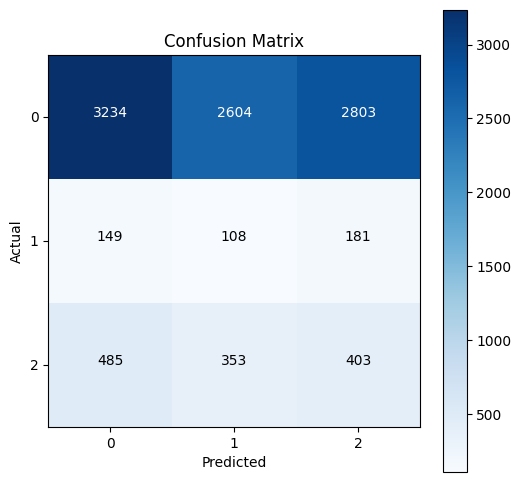

In [22]:
plot_confusion_matrix(actual_labels, predicted_labels)

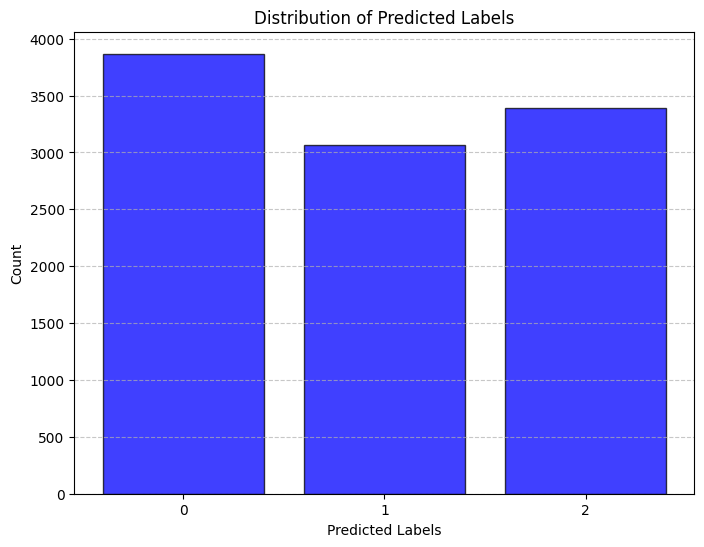

In [13]:
plt.figure(figsize=(8, 6))
plt.hist(predicted_labels, bins=np.arange(4) - 0.5, rwidth=0.8, alpha=0.75, color='blue', edgecolor='black')
plt.xticks(range(3))
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()